## This code generates the empirical results in the paper (Sec. 5).  The 18 degree sequences used in the experiements are obtained from the study conducted by A. Broido and A. Clauset (published in Nature Communications 2019). The "importfiles.py" method that we use is written by the authors of that study. The datasets are also available in the network form via the Colorado ICON network data library. 

In [54]:
%reload_ext autoreload
%autoreload 2
import sys
import pandas as pd
sys.path.append('../code/')
import matplotlib.pyplot as plt

from scipy.stats import pareto
import os
import importfiles as im
from collections import Counter

import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import pareto
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.io
import collections
import pickle
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)

In [2]:
def estimate_alpha_MODIFIED_FRAC_with_discrete(fp, k_min, frac, n_iter):
    ''' 
    Given a degree sequence, estimate the power-law coefficients using vanilla and FP based methods for
       
    '''

    x = im.readdata(fp)

    deg_sequence = [i for i in x if i>= k_min]
    D = np.sum(deg_sequence) # Sum of the degrees in the tail
    prob = [d/D for d in deg_sequence] #Probabilities with which the random friends are sampled
    
    n = np.min([int(np.ceil(frac * len(deg_sequence))), 1000]) #number of samples based on the specified fraction 'frac'
   
    alpha_MLE_X_vec = []
    alpha_MLE_X_discrete_vec = []
    alpha_MLE_Y_vec = []
    alpha_MLE_Y_discrete_vec = []

    iterations = 0
    while iterations < n_iter:        
        # The degrees (d(X_1), d(X_2),....d(X_n)) of the n random nodes and,
        # the degrees (d(Y_1), d(Y_2),....d(Y_n)) of n random friends are stored as lists XX and YY respectively
        XX = list(np.random.choice(deg_sequence, size=n))
        YY = list(np.random.choice(deg_sequence, size=n, p=prob))
        
        # Computing the vanilla MLE
        alpha_MLE_X = len(XX)/np.sum([np.log(x/k_min) for x in XX]) + 1
        alpha_MLE_X_vec.append(alpha_MLE_X)

        # Computing the vanilla MLE with discrete adaptation
        alpha_MLE_X_discrete = len(XX)/np.sum([np.log(x/(k_min-0.5)) for x in XX]) + 1
        alpha_MLE_X_discrete_vec.append(alpha_MLE_X_discrete)
        
        # Computing the friendship paradox based MLE
        alpha_MLE_Y = len(YY)/np.sum([np.log(y/(k_min)) for y in YY]) + 2
        alpha_MLE_Y_vec.append(alpha_MLE_Y)
        
        # Computing the friendship paradox based MLE with discrete adaptation
        alpha_MLE_Y_discrete = len(YY)/np.sum([np.log(y/(k_min-0.5)) for y in YY]) + 2
        alpha_MLE_Y_discrete_vec.append(alpha_MLE_Y_discrete)
        
        iterations +=1
    
    print('sample size = ' + str(n))    
    return((alpha_MLE_X_vec, alpha_MLE_X_discrete_vec, alpha_MLE_Y_vec, alpha_MLE_Y_discrete_vec))
    

# Generating subplots

### Biological Networks

In [32]:
deg_dir = 'degree_sequences/'
dict_selected_fn_biological = {
    'Ito_core_yeast_interactome_2001_Ito-core_Biological_Protein_interactions_n3.gmldistribution.txt':{'k_min':1},
    'Yu_yeast_interactomes_2008_CCSB-YI1_Biological_Protein_interactions_n4.gmldistribution.txt':{'k_min':1},
    'Kato_plant-pollinator_web_Kato_plant-pollinator_web_Biological_Food_web_n3.gml_bipartitefull_weightedsimplifieddistribution.txt':{'k_min':1},
    'Binary_interactomes_various_species_2012_M_musculus_mouse_binary_hq_Biological_Protein_interactions_n4.gmldistribution.txt':{'k_min':2},
    'Binary_interactomes_various_species_2012_S_pombe_972H_fission_yeast_binary_hq_Biological_Protein_interactions_n3.gmldistribution.txt':{'k_min':2},
    'Binary_interactomes_various_species_2012_S_pombe_972H_fission_yeast_cocomp_hq_Biological_Protein_interactions_n3.gmldistribution.txt':{'k_min':1},
    'C_elegans_interactomes_2009_BPmaps_scaffold_Biological_Protein_interactions_n3.gmldistribution.txt':{'k_min':1},
    'C_elegans_interactomes_2009_WI8_Biological_Protein_interactions_n4.gmldistribution.txt':{'k_min':1},
    'C_elegans_interactomes_2009_WI-2007_Biological_Protein_interactions_n4.gmldistribution.txt':{'k_min':1},
    'C_elegans_interactomes_2009_WI-2004_Biological_Protein_interactions_n4.gmldistribution.txt':{'k_min':1},  
    'Metabolic_networks_from_KEGG_2006_spr_Biological_Metabolic_n4.gml_multigraphsimplifieddistribution.txt':{'k_min':3},
    'Metabolic_networks_from_KEGG_2006_uur_Biological_Metabolic_n3.gml_multigraphsimplifieddistribution.txt':{'k_min':2},
}

sample size = 41
sample size = 64
sample size = 39
sample size = 53
sample size = 12
sample size = 26
sample size = 27
sample size = 127
sample size = 75
sample size = 62
sample size = 24
sample size = 16


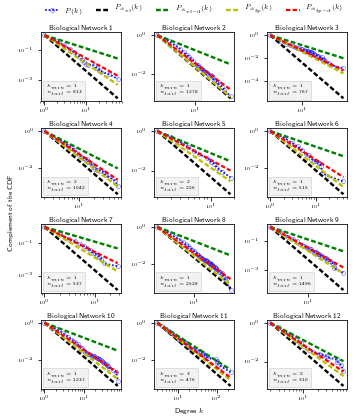

In [33]:
frac = 0.05
n_iter = 1000
bio_net_no = 1
tech_net_no = 1
info_net_no = 1

fnV = list(dict_selected_fn_biological.keys())
Tot = len(dict_selected_fn_biological.keys())
Cols = 3

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = list(np.arange(1,Tot + 1,1).astype(int))

fig = plt.figure(1, figsize=(5.49, 6.2))
# plt.xlabel(r'Degree $k$', fontsize=7)
# plt.ylabel(r'CCDF', fontsize=7)
fig.text(0.5, 0.03, r'Degree $k$', fontsize=7, ha='center')
fig.text(0.04, 0.55, r'Complement of the CDF', fontsize=7, rotation='vertical')

for k in Position:
    
    fn = fnV[k-1]
    fp = deg_dir + fn
    k_min = dict_selected_fn_biological[fn]['k_min']
    
    estimate = estimate_alpha_MODIFIED_FRAC_with_discrete(fp, k_min, frac, n_iter)

    alpha_MLE_X_vec = estimate[0]
    alpha_MLE_X_discrete_vec = estimate[1]
    alpha_MLE_Y_vec = estimate[2]
    alpha_MLE_Y_discrete_vec = estimate[3]

    alpha_MLE_X = np.mean([x for x in alpha_MLE_X_vec if x < np.inf])   
    alpha_MLE_X_discrete = np.mean(alpha_MLE_X_discrete_vec)
    alpha_MLE_Y = np.mean(alpha_MLE_Y_vec)   
    alpha_MLE_Y_discrete = np.mean(alpha_MLE_Y_discrete_vec)  
    
    x = im.readdata(fp)

    deg_sequence = [i for i in x if i>= k_min]
    E_PDF = Counter(deg_sequence)

    total = sum(E_PDF.values(), 0.0)

    for key in E_PDF:
        E_PDF[key] /= total

    E_CCDF = {}
    CCDF_vanilla = {}
    CCDF_vanilla_discrete = {}
    CCDF_FP = {}
    CCDF_FP_discrete = {}

    D_vanilla = {}
    D_vanilla_discrete = {}
    D_FP ={}
    D_FP_discrete ={}
    for key in E_PDF:
        E_CCDF[key] = sum([E_PDF[k] for k in E_PDF.keys() if k >= key])
        CCDF_vanilla[key] = 1 - pareto.cdf(key, b = alpha_MLE_X - 1, loc=0, scale=k_min)
        CCDF_vanilla_discrete[key] = 1 - pareto.cdf(key, b = alpha_MLE_X_discrete - 1, loc=0, scale=k_min)
        CCDF_FP[key] = 1 - pareto.cdf(key, b = alpha_MLE_Y - 1, loc=0, scale=k_min)    
        CCDF_FP_discrete[key] = 1 - pareto.cdf(key, b = alpha_MLE_Y_discrete - 1, loc=0, scale=k_min)

        if key != k_min:
            D_vanilla[key] = np.abs( CCDF_vanilla[key] - E_CCDF[key] )/(np.sqrt(CCDF_vanilla[key] *(1 - CCDF_vanilla[key])))
            D_vanilla_discrete[key] = np.abs( CCDF_vanilla_discrete[key] - E_CCDF[key] )/(np.sqrt(CCDF_vanilla_discrete[key] *(1 - CCDF_vanilla_discrete[key])))
            D_FP[key] = np.abs( CCDF_FP[key] - E_CCDF[key] )/(np.sqrt(CCDF_FP[key] *(1 - CCDF_FP[key])))
            D_FP_discrete[key] = np.abs( CCDF_FP_discrete[key] - E_CCDF[key] )/(np.sqrt(CCDF_FP_discrete[key] *(1 - CCDF_FP_discrete[key])))
                       
    dict_selected_fn_biological[fn]['n_tail'] = len(deg_sequence)
                
    dict_selected_fn_biological[fn]['alpha_MLE_X'] = alpha_MLE_X
    dict_selected_fn_biological[fn]['alpha_MLE_X_discrete'] = alpha_MLE_X_discrete
    dict_selected_fn_biological[fn]['alpha_MLE_Y'] = alpha_MLE_Y
    dict_selected_fn_biological[fn]['alpha_MLE_Y_discrete'] = alpha_MLE_Y_discrete
    
    dict_selected_fn_biological[fn]['KS_X'] = np.max(list(D_vanilla.values()))
    dict_selected_fn_biological[fn]['KS_X_discrete'] = np.max(list(D_vanilla_discrete.values()))
    dict_selected_fn_biological[fn]['KS_Y'] = np.max(list(D_FP.values()))
    dict_selected_fn_biological[fn]['KS_Y_discrete'] = np.max(list(D_FP_discrete.values()))
    
    dict_selected_fn_biological[fn]['Var_X'] = np.var(alpha_MLE_X_vec)
    dict_selected_fn_biological[fn]['Var_X_discrete'] = np.var(alpha_MLE_X_discrete_vec)
    dict_selected_fn_biological[fn]['Var_Y'] = np.var(alpha_MLE_Y_vec)
    dict_selected_fn_biological[fn]['Var_Y_discrete'] = np.var(alpha_MLE_Y_discrete_vec)
    
    # Setting up the parameters of the plot
    ax = fig.add_subplot(Rows,Cols,Position[k-1])
    plt.rc('text', usetex=True)
    MarkerSize = 5
    MarkerEdgeWidth = 0.4    
    LineWidth = 2.0
    alpha = 0.7
    plt.xscale('log')
    plt.yscale('log')

    # Plotting the values of empirical and theoretical CCDF values
    ax.plot(E_CCDF.keys(),
            E_CCDF.values(),
            linestyle='--',
            dashes=(1, 1),
            marker='o',
            alpha=alpha+0.2,
            markerfacecolor='none',
            markeredgecolor='b',
            c='b',
            linewidth=LineWidth - 0.2,
            markersize=MarkerSize - 1,
            markeredgewidth=MarkerEdgeWidth,                    
            label = r'$P(k)$')

    X_VALS = np.arange(np.min(list(E_CCDF.keys())), np.max(list(E_CCDF.keys())), 0.1)
    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_X - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='k',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{vl}}}(k)$')

    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_X_discrete - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='g',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{vl-d}}}(k)$')

    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_Y - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='y',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{fp}}}(k)$')    
    
    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_Y_discrete - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='r',
            linewidth=LineWidth + 0.2,
            label = r'$P_{\hat{\alpha}_{\mathrm{fp-d}}} (k)$')
    
    ax.text(0.08, .1, 
             '$k_{min}=\,\,$' + str(k_min) + '\n$n_{tail}=\,\,$' + str(len(deg_sequence)),
            bbox=dict(facecolor='grey', alpha=0.1), 
            fontsize=5, 
            transform=ax.transAxes)
    
    title = ''
    if 'Biological' in fn:
        title = 'Biological Network ' + str(bio_net_no)
        bio_net_no += 1
    if 'Technological' in fn:
        title = 'Technological Network ' + str(tech_net_no)
        tech_net_no += 1
    if 'Informational' in fn:
        title = 'Informational Network ' + str(info_net_no)
        info_net_no += 1
    dict_selected_fn_biological[fn]['Name'] = title   
        
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.subplots_adjust(bottom = 0.08, wspace=0.4, hspace=0.38)
    plt.title(title, fontsize=7, pad=3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=5, fontsize=7, bbox_to_anchor=(0.49, +0.92), edgecolor = 'none')    
plt.savefig('Empirical_Results_Biological.pdf', bbox_inches='tight')





In [34]:
Rows = list(dict_selected_fn_biological.keys())
Cols = [
 'Name',
 'n_tail',
 'k_min',
 'alpha_MLE_X',
 'alpha_MLE_X_discrete',
 'alpha_MLE_Y',
 'alpha_MLE_Y_discrete',
 'KS_X',
 'KS_X_discrete',
 'KS_Y',          
 'KS_Y_discrete',     
 'Var_X',
 'Var_X_discrete',
 'Var_Y',
 'Var_Y_discrete']

df_results_biological  =  pd.DataFrame(index = Rows, columns = Cols)
for row in Rows:
    for col in Cols:
        df_results_biological[col][row] = dict_selected_fn_biological[row][col]

In [35]:
df_results_biological['KS_X/KS_Y_discrete'] = ""
df_results_biological['KS_X_discrete/KS_Y_discrete'] = ""
df_results_biological['KS_Y/KS_Y_discrete'] = ""
df_results_biological['Var_X/Var_Y_discrete'] = ""
df_results_biological['Var_X_discrete/Var_Y_discrete'] = ""
df_results_biological['Var_Y/Var_Y_discrete'] = ""
for row in Rows:
    df_results_biological['KS_X/KS_Y_discrete'][row] = df_results_biological['KS_X'][row]/df_results_biological['KS_Y_discrete'][row]
    df_results_biological['KS_X_discrete/KS_Y_discrete'][row] = df_results_biological['KS_X_discrete'][row]/df_results_biological['KS_Y_discrete'][row]
    df_results_biological['KS_Y/KS_Y_discrete'][row] = df_results_biological['KS_Y'][row]/df_results_biological['KS_Y_discrete'][row]    
    
    df_results_biological['Var_X/Var_Y_discrete'][row] = df_results_biological['Var_X'][row]/df_results_biological['Var_Y_discrete'][row]
    df_results_biological['Var_X_discrete/Var_Y_discrete'][row] = df_results_biological['Var_X_discrete'][row]/df_results_biological['Var_Y_discrete'][row]
    df_results_biological['Var_Y/Var_Y_discrete'][row] = df_results_biological['Var_Y'][row]/df_results_biological['Var_Y_discrete'][row]   

In [ ]:
df_results_biological

### Technological and Informational Networks

In [10]:
deg_dir = 'degree_sequences/'
dict_selected_fn_techinfo = {
    'Word_Adjacency_Networks_japanesebookinter_st_Informational_Language_n4.gmldistribution.txt':{'k_min':2},
    'Word_Adjacency_Networks_spanishbookinter_st_Informational_Language_n5.gmldistribution.txt':{'k_min':2},    
    'Amazon_book_similarities_2008_amazon-2008_Informational_Relatedness_n6.gml_multigraphsimplifieddistribution.txt':{'k_min':11},
    'Python_Dependency_Network_requirements_Technological_Software_n5.gml_directedtotaldistribution.txt':{'k_min':3},
    'Python_Dependency_Network_requirements_Technological_Software_n5.gml_directedindistribution.txt':{'k_min':1},
    'Software_function-callgraphs_2002_Linux_kernel_v2_4_19_Technological_Software_n4.gml_directedindistribution.txt':{'k_min':1},    
}

sample size = 98
sample size = 421
sample size = 1000
sample size = 537
sample size = 423
sample size = 193


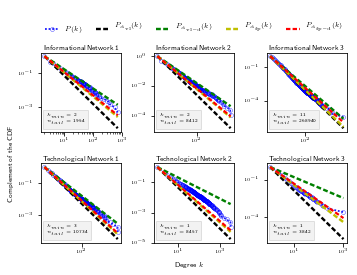

In [11]:
frac = 0.05
n_iter = 1000
bio_net_no = 1
tech_net_no = 1
info_net_no = 1

fnV = list(dict_selected_fn_techinfo.keys())
Tot = len(dict_selected_fn_techinfo.keys())
Cols = 3

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = list(np.arange(1,Tot + 1,1).astype(int))

fig = plt.figure(1, figsize=(5.49, 3.3))
# plt.xlabel(r'Degree $k$', fontsize=7)
# plt.ylabel(r'CCDF', fontsize=7)
fig.text(0.5, -0.02, r'Degree $k$', fontsize=7, ha='center')
fig.text(0.04, 0.55, r'Complement of the CDF', fontsize=7, rotation='vertical')

for k in Position:
    
    fn = fnV[k-1]
    fp = deg_dir + fn
    k_min = dict_selected_fn_techinfo[fn]['k_min']
    
    estimate = estimate_alpha_MODIFIED_FRAC_with_discrete(fp, k_min, frac, n_iter)

    alpha_MLE_X_vec = estimate[0]
    alpha_MLE_X_discrete_vec = estimate[1]
    alpha_MLE_Y_vec = estimate[2]
    alpha_MLE_Y_discrete_vec = estimate[3]

    alpha_MLE_X = np.mean([x for x in alpha_MLE_X_vec if x < np.inf])   
    alpha_MLE_X_discrete = np.mean(alpha_MLE_X_discrete_vec)
    alpha_MLE_Y = np.mean(alpha_MLE_Y_vec)   
    alpha_MLE_Y_discrete = np.mean(alpha_MLE_Y_discrete_vec)  
    
    x = im.readdata(fp)

    deg_sequence = [i for i in x if i>= k_min]
    E_PDF = Counter(deg_sequence)

    total = sum(E_PDF.values(), 0.0)

    for key in E_PDF:
        E_PDF[key] /= total

    E_CCDF = {}
    CCDF_vanilla = {}
    CCDF_vanilla_discrete = {}
    CCDF_FP = {}
    CCDF_FP_discrete = {}

    D_vanilla = {}
    D_vanilla_discrete = {}
    D_FP ={}
    D_FP_discrete ={}
    for key in E_PDF:
        E_CCDF[key] = sum([E_PDF[k] for k in E_PDF.keys() if k >= key])
        CCDF_vanilla[key] = 1 - pareto.cdf(key, b = alpha_MLE_X - 1, loc=0, scale=k_min)
        CCDF_vanilla_discrete[key] = 1 - pareto.cdf(key, b = alpha_MLE_X_discrete - 1, loc=0, scale=k_min)
        CCDF_FP[key] = 1 - pareto.cdf(key, b = alpha_MLE_Y - 1, loc=0, scale=k_min)    
        CCDF_FP_discrete[key] = 1 - pareto.cdf(key, b = alpha_MLE_Y_discrete - 1, loc=0, scale=k_min)

        if key != k_min:
            D_vanilla[key] = np.abs( CCDF_vanilla[key] - E_CCDF[key] )/(np.sqrt(CCDF_vanilla[key] *(1 - CCDF_vanilla[key])))
            D_vanilla_discrete[key] = np.abs( CCDF_vanilla_discrete[key] - E_CCDF[key] )/(np.sqrt(CCDF_vanilla_discrete[key] *(1 - CCDF_vanilla_discrete[key])))
            D_FP[key] = np.abs( CCDF_FP[key] - E_CCDF[key] )/(np.sqrt(CCDF_FP[key] *(1 - CCDF_FP[key])))
            D_FP_discrete[key] = np.abs( CCDF_FP_discrete[key] - E_CCDF[key] )/(np.sqrt(CCDF_FP_discrete[key] *(1 - CCDF_FP_discrete[key])))
                       
    dict_selected_fn_techinfo[fn]['n_tail'] = len(deg_sequence)
                
    dict_selected_fn_techinfo[fn]['alpha_MLE_X'] = alpha_MLE_X
    dict_selected_fn_techinfo[fn]['alpha_MLE_X_discrete'] = alpha_MLE_X_discrete
    dict_selected_fn_techinfo[fn]['alpha_MLE_Y'] = alpha_MLE_Y
    dict_selected_fn_techinfo[fn]['alpha_MLE_Y_discrete'] = alpha_MLE_Y_discrete
    
    dict_selected_fn_techinfo[fn]['KS_X'] = np.max(list(D_vanilla.values()))
    dict_selected_fn_techinfo[fn]['KS_X_discrete'] = np.max(list(D_vanilla_discrete.values()))
    dict_selected_fn_techinfo[fn]['KS_Y'] = np.max(list(D_FP.values()))
    dict_selected_fn_techinfo[fn]['KS_Y_discrete'] = np.max(list(D_FP_discrete.values()))
    
    dict_selected_fn_techinfo[fn]['Var_X'] = np.var(alpha_MLE_X_vec)
    dict_selected_fn_techinfo[fn]['Var_X_discrete'] = np.var(alpha_MLE_X_discrete_vec)
    dict_selected_fn_techinfo[fn]['Var_Y'] = np.var(alpha_MLE_Y_vec)
    dict_selected_fn_techinfo[fn]['Var_Y_discrete'] = np.var(alpha_MLE_Y_discrete_vec)
    
    # Setting up the parameters of the plot
    ax = fig.add_subplot(Rows,Cols,Position[k-1])
    plt.rc('text', usetex=True)
    MarkerSize = 5
    MarkerEdgeWidth = 0.4    
    LineWidth = 2.0
    alpha = 0.7
    plt.xscale('log')
    plt.yscale('log')

    # Plotting the values of empirical and theoretical CCDF values
    ax.plot(E_CCDF.keys(),
            E_CCDF.values(),
            linestyle='--',
            dashes=(1, 1),
            marker='o',
            alpha=alpha+0.2,
            markerfacecolor='none',
            markeredgecolor='b',
            c='b',
            linewidth=LineWidth - 0.2,
            markersize=MarkerSize - 1,
            markeredgewidth=MarkerEdgeWidth,                    
            label = r'$P(k)$')

    X_VALS = np.arange(np.min(list(E_CCDF.keys())), np.max(list(E_CCDF.keys())), 0.1)
    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_X - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='k',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{vl}}}(k)$')

    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_X_discrete - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='g',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{vl-d}}}(k)$')

    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_Y - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='y',
            linewidth=LineWidth + 0.4,
            label = r'$P_{\hat{\alpha}_{\mathrm{fp}}}(k)$')    
    
    ax.plot(X_VALS,
            [(1 - pareto.cdf(i, b = alpha_MLE_Y_discrete - 1, loc=0, scale=k_min)) for i in X_VALS],
            linestyle='--',
            dashes=(2, 1),
            c='r',
            linewidth=LineWidth + 0.2,
            label = r'$P_{\hat{\alpha}_{\mathrm{fp-d}}} (k)$')
    
    ax.text(0.08, .1, 
             '$k_{min}=\,\,$' + str(k_min) + '\n$n_{tail}=\,\,$' + str(len(deg_sequence)),
            bbox=dict(facecolor='grey', alpha=0.1), 
            fontsize=5, 
            transform=ax.transAxes)
    
    title = ''
    if 'Biological' in fn:
        title = 'Biological Network ' + str(bio_net_no)
        bio_net_no += 1
    if 'Technological' in fn:
        title = 'Technological Network ' + str(tech_net_no)
        tech_net_no += 1
    if 'Informational' in fn:
        title = 'Informational Network ' + str(info_net_no)
        info_net_no += 1
    dict_selected_fn_techinfo[fn]['Name'] = title   
        
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.subplots_adjust(bottom = 0.08, wspace=0.4, hspace=0.4)
    plt.title(title, fontsize=7, pad=3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=5, fontsize=7, bbox_to_anchor=(0.49, +1.04), edgecolor = 'none')    
plt.savefig('Empirical_Results_techinfo.pdf', bbox_inches='tight')

In [12]:
Rows = list(dict_selected_fn_techinfo.keys())
Cols = [
 'Name',
 'n_tail',
 'k_min',
 'alpha_MLE_X',
 'alpha_MLE_X_discrete',
 'alpha_MLE_Y',
 'alpha_MLE_Y_discrete',
 'KS_X',
 'KS_X_discrete',
 'KS_Y',          
 'KS_Y_discrete',     
 'Var_X',
 'Var_X_discrete',
 'Var_Y',
 'Var_Y_discrete']

df_results_techinfo  =  pd.DataFrame(index = Rows, columns = Cols)
for row in Rows:
    for col in Cols:
        df_results_techinfo[col][row] = dict_selected_fn_techinfo[row][col]

In [13]:
df_results_techinfo['KS_X/KS_Y_discrete'] = ""
df_results_techinfo['KS_X_discrete/KS_Y_discrete'] = ""
df_results_techinfo['KS_Y/KS_Y_discrete'] = ""
df_results_techinfo['Var_X/Var_Y_discrete'] = ""
df_results_techinfo['Var_X_discrete/Var_Y_discrete'] = ""
df_results_techinfo['Var_Y/Var_Y_discrete'] = ""
for row in Rows:
    df_results_techinfo['KS_X/KS_Y_discrete'][row] = df_results_techinfo['KS_X'][row]/df_results_techinfo['KS_Y_discrete'][row]
    df_results_techinfo['KS_X_discrete/KS_Y_discrete'][row] = df_results_techinfo['KS_X_discrete'][row]/df_results_techinfo['KS_Y_discrete'][row]
    df_results_techinfo['KS_Y/KS_Y_discrete'][row] = df_results_techinfo['KS_Y'][row]/df_results_techinfo['KS_Y_discrete'][row]    
    
    df_results_techinfo['Var_X/Var_Y_discrete'][row] = df_results_techinfo['Var_X'][row]/df_results_techinfo['Var_Y_discrete'][row]
    df_results_techinfo['Var_X_discrete/Var_Y_discrete'][row] = df_results_techinfo['Var_X_discrete'][row]/df_results_techinfo['Var_Y_discrete'][row]
    df_results_techinfo['Var_Y/Var_Y_discrete'][row] = df_results_techinfo['Var_Y'][row]/df_results_techinfo['Var_Y_discrete'][row]   


In [14]:
df_results_techinfo['KS_X/KS_Y_discrete'] = ""
df_results_techinfo['KS_X_discrete/KS_Y_discrete'] = ""
df_results_techinfo['KS_Y/KS_Y_discrete'] = ""
df_results_techinfo['Var_X/Var_Y_discrete'] = ""
df_results_techinfo['Var_X_discrete/Var_Y_discrete'] = ""
df_results_techinfo['Var_Y/Var_Y_discrete'] = ""
for row in Rows:
    df_results_techinfo['KS_X/KS_Y_discrete'][row] = df_results_techinfo['KS_X'][row]/df_results_techinfo['KS_Y_discrete'][row]
    df_results_techinfo['KS_X_discrete/KS_Y_discrete'][row] = df_results_techinfo['KS_X_discrete'][row]/df_results_techinfo['KS_Y_discrete'][row]
    df_results_techinfo['KS_Y/KS_Y_discrete'][row] = df_results_techinfo['KS_Y'][row]/df_results_techinfo['KS_Y_discrete'][row]    
    
    df_results_techinfo['Var_X/Var_Y_discrete'][row] = df_results_techinfo['Var_X'][row]/df_results_techinfo['Var_Y_discrete'][row]
    df_results_techinfo['Var_X_discrete/Var_Y_discrete'][row] = df_results_techinfo['Var_X_discrete'][row]/df_results_techinfo['Var_Y_discrete'][row]
    df_results_techinfo['Var_Y/Var_Y_discrete'][row] = df_results_techinfo['Var_Y'][row]/df_results_techinfo['Var_Y_discrete'][row]   

In [ ]:
df_results_techinfo

## Merging and saving the results

In [ ]:
df_results = pd.concat([df_results_biological, df_results_techinfo])
df_results

In [39]:
#Saving the results dataframe
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open('df_results.p', 'wb') as fp:
    pickle.dump(df_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
#Loading the results dataframe
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle
    
#Loading the results dataframe
with open('df_results.p', 'rb') as fp:
    df_results = pickle.load(fp)

In [ ]:
df_results

In [42]:
df_results = df_results[['Name', 'n_tail', 'k_min', 'alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y',
       'alpha_MLE_Y_discrete', 'KS_X', 'KS_X_discrete', 'KS_Y',
       'KS_Y_discrete', 'Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']]

In [ ]:
df_results[['n_tail', 'k_min']] = df_results[['n_tail', 'k_min']].astype('int')
df_results[['alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y',
       'alpha_MLE_Y_discrete', 'KS_X', 'KS_X_discrete', 'KS_Y',
       'KS_Y_discrete', 'Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']] = df_results[['alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y',
       'alpha_MLE_Y_discrete', 'KS_X', 'KS_X_discrete', 'KS_Y',
       'KS_Y_discrete', 'Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']].astype('float')
print(df_results.dtypes)

In [ ]:
df_results

In [ ]:
df_results.columns

In [ ]:
for col in ['alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y', 'alpha_MLE_Y_discrete', 
            'KS_X', 'KS_X_discrete', 'KS_Y', 'KS_Y_discrete']:
    df_results[col] = df_results[col].map('{:.3g}'.format)
    
for col in ['Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']:
    df_results[col] = df_results[col].map('{:.2e}'.format)  

In [ ]:
df_results.set_index('Name')

In [ ]:
print(df_results.set_index('Name').to_latex())

## Visualizing the minimum variance and KS-statistic

In [ ]:
df_results[['n_tail', 'k_min']] = df_results[['n_tail', 'k_min']].astype('int')
df_results[['alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y',
       'alpha_MLE_Y_discrete', 'KS_X', 'KS_X_discrete', 'KS_Y',
       'KS_Y_discrete', 'Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']] = df_results[['alpha_MLE_X', 'alpha_MLE_X_discrete', 'alpha_MLE_Y',
       'alpha_MLE_Y_discrete', 'KS_X', 'KS_X_discrete', 'KS_Y',
       'KS_Y_discrete', 'Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']].astype('float')
print(df_results.dtypes)

In [53]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)


df_results.style.apply(highlight_min, axis = 1, color = 'bisque', subset = ['Var_X', 'Var_X_discrete', 'Var_Y', 'Var_Y_discrete']).apply(highlight_min, axis = 1, color = 'bisque', subset = ['KS_X', 'KS_X_discrete', 'KS_Y', 'KS_Y_discrete'])

,Name,n_tail,k_min,alpha_MLE_X,alpha_MLE_X_discrete,alpha_MLE_Y,alpha_MLE_Y_discrete,KS_X,KS_X_discrete,KS_Y,KS_Y_discrete,Var_X,Var_X_discrete,Var_Y,Var_Y_discrete
Ito_core_yeast_interactome_2001_Ito-core_Biological_Protein_interactions_n3.gmldistribution.txt,Biological Network 1,813,1,3.41,1.89,2.89,2.55,0.534,0.385,0.288,0.117,0.378,0.00623,0.0177,0.00244
Yu_yeast_interactomes_2008_CCSB-YI1_Biological_Protein_interactions_n4.gmldistribution.txt,Biological Network 2,1278,1,2.66,1.77,2.62,2.43,0.369,0.359,0.349,0.245,0.0732,0.0032,0.00368,0.000855
Kato_plant-pollinator_web_Kato_plant-pollinator_web_Biological_Food_web_n3.gml_bipartitefull_weightedsimplifieddistribution.txt,Biological Network 3,767,1,3.41,1.88,2.46,2.35,1.08,0.431,0.163,0.132,0.765,0.0106,0.00324,0.00104
Binary_interactomes_various_species_2012_M_musculus_mouse_binary_hq_Biological_Protein_interactions_n4.gmldistribution.txt,Biological Network 4,1042,2,3.35,2.39,3.06,2.81,0.322,0.194,0.189,0.0739,0.199,0.0236,0.0171,0.00574
Binary_interactomes_various_species_2012_S_pombe_972H_fission_yeast_binary_hq_Biological_Protein_interactions_n3.gmldistribution.txt,Biological Network 5,226,2,4.36,2.61,3.67,3.11,0.612,0.196,0.334,0.141,4.94,0.126,0.279,0.0471
Binary_interactomes_various_species_2012_S_pombe_972H_fission_yeast_cocomp_hq_Biological_Protein_interactions_n3.gmldistribution.txt,Biological Network 6,515,1,3.11,1.84,2.87,2.54,0.506,0.398,0.383,0.211,0.412,0.00839,0.0229,0.00321
C_elegans_interactomes_2009_BPmaps_scaffold_Biological_Protein_interactions_n3.gmldistribution.txt,Biological Network 7,537,1,3.69,1.92,2.89,2.55,0.697,0.372,0.224,0.0781,1.01,0.0103,0.0251,0.00337
C_elegans_interactomes_2009_WI8_Biological_Protein_interactions_n4.gmldistribution.txt,Biological Network 8,2528,1,2.65,1.77,2.56,2.4,0.356,0.326,0.296,0.191,0.0408,0.00188,0.00138,0.000371
C_elegans_interactomes_2009_WI-2007_Biological_Protein_interactions_n4.gmldistribution.txt,Biological Network 9,1496,1,3.26,1.87,2.67,2.46,0.477,0.352,0.142,0.0361,0.193,0.00395,0.00416,0.000889
C_elegans_interactomes_2009_WI-2004_Biological_Protein_interactions_n4.gmldistribution.txt,Biological Network 10,1237,1,2.8,1.79,2.6,2.42,0.404,0.352,0.281,0.169,0.114,0.00399,0.00344,0.000833
